# RGI08 (Scandinavia)

F. Maussion & S. Galos

Same as RGI6 except for sweden. Details:
- in Northern Norway there is a new inventory by Liss but we decided to not use it for consistency (not super strong opinions)
- shifted outlines for sweden

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, find_duplicates, correct_geoms
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 8

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '07_rgi60_Scandinavia.zip')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, _ = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
611,3143,2674.9,"Andreassen, Winsvold",Winsvold,2012,Norway,2006,1999,2006
695,140,95.6,"Andreassen, Stokes",Andreassen,2018,Norway,2014,2014,2014
717,234,289.3,Baumann,Baumann,2021,Norway,1750,1750,1750
725,2383,1649.1,"Andreassen, Winsvold",Andreassen,2018,Norway,1988,1988,1997
733,219,101.9,"Andreassen, Leigh",Andreassen,2020,Norway,1989,1989,1989
737,228,96.1,"Andreassen, Leigh",Andreassen,2020,Norway,1994,1994,1994
738,237,82.0,"Andreassen, Leigh",Andreassen,2020,Norway,1999,1999,1999
739,246,81.9,"Andreassen, Leigh",Andreassen,2020,Norway,2006,2006,2006
740,249,74.0,"Andreassen, Leigh",Andreassen,2020,Norway,2011,2011,2011


- 611 is RGI6 but for Norway only (many outlines stop at the border...)
- 362 is RGI6 in Sweden (middle Lappland)
- 363 is RGI6 in Sweden (northern Lappland)
- 364 is RGI6 in Sweden (southern Lappland)
- 365 is RGI6 in Sweden (Jämtland)
- 733 to 742: new regions for parts of northern norway. We may decide to use 738 in replacement for 611 where possible
- 758: merging of a few outlines at the border - it replaced the old submissions that were replaced
- 812: rectification of RGI6 outlines in Sweden

In [5]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

For now, we stick to reproducing RGI6 in Norway, and use the updated outlines for sweden

In [6]:
# OLD: pure RGI6
# do that based on relevant submission IDs (611, 362, 363, 364, 365, 758)
# rgi7 = (shp.loc[shp['subm_id'].isin([611, 362, 363, 364, 365, 758])]).copy()
# rgi7['is_rgi6'] = True

In [7]:
# New
rgi7 = (shp.loc[shp['subm_id'].isin([611, 812])]).copy()
rgi7['is_rgi6'] = True
rgi7.loc[rgi7['subm_id'] == 812, 'is_rgi6'] = False

In [8]:
# These IDs have been remapped in 812 but actually should not have
dups = [1012468, 1012469, 1012477, 1012480, 1012481, 1012484, 1012562, 1012567, 1012573, 1012632, 1012674, 1012667, 1012656, 1012740]
rgi7 = rgi7.loc[~ rgi7.anlys_id.isin(dups)].copy()

In [9]:
# Size filter?
print(len(rgi7))
rgi7 = size_filter(rgi7)
len(rgi7)

3413


3411

### Uncomment below if you want to update with the new inventory

OK now take care of the new inventory. We need to make a geometry around it for selection: 

In [10]:
# new = (shp.loc[shp['subm_id'].isin([738])]).copy()
# new['is_rgi6'] = False

# # Size filter?
# print(len(new))
# new = size_filter(new)
# len(new)

Make a box aroun the region (I checked in GIS, it's ok to do so):

In [11]:
# import shapely.geometry as shpg
# hull = gpd.GeoDataFrame({'geometry':[shpg.MultiPolygon(new.geometry.values).convex_hull]})
# hull.crs = new.crs

# f, ax = plt.subplots(figsize=(8, 12))
# hull.plot(ax=ax, edgecolor='k');
# new.plot(ax=ax, facecolor='C3', edgecolor='k');

In [12]:
# # Remove all old rgi outlines
# rp = rgi7.representative_point()
# rp = rp.to_frame('geometry')
# rp['orig_index'] = rgi7.index

# # Find non overlying polygons
# difference = gpd.overlay(rp, hull, how='difference')

# # Create new rgi
# rgi7 = rgi7.loc[difference['orig_index']].copy()
# assert rgi7.anlys_id.isin([355145]).sum() == 0  # This is the only geometry down there which might have not fit in the polygon

In [13]:
# # Merge
# rgi7 = pd.concat([rgi7, new])

### Some sanity checks 

In [14]:
dupes = find_duplicates(rgi7)

Seems Okay!


In [15]:
rgi7 = correct_geoms(rgi7)

Found 90 invalid geometries out of 3411. Correcting...
After correction, 0 geometries are still invalid.
Area changed by -55.2 m2 (-0.0000%)


In [16]:
needs_size_filter(rgi7)

False

In [17]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
611,3142,3142
812,269,269


In [18]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

### Plots 

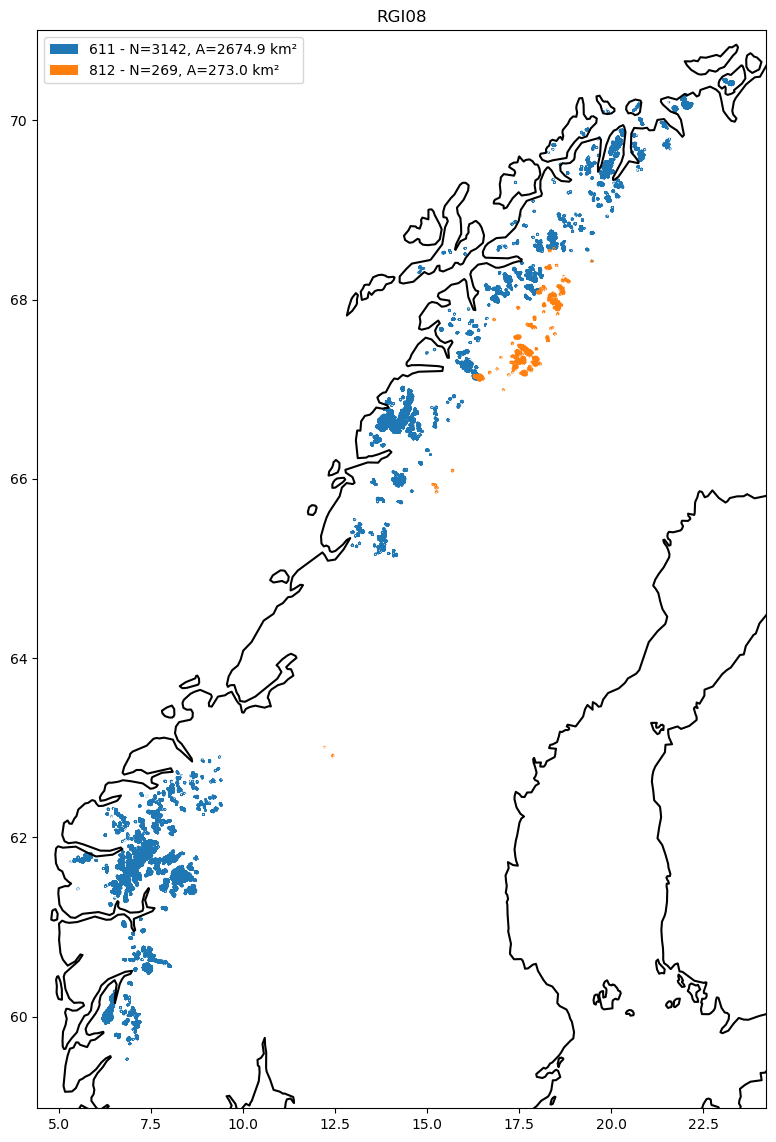

In [19]:
plot_map(rgi7, reg, loc='upper left', linewidth=2)

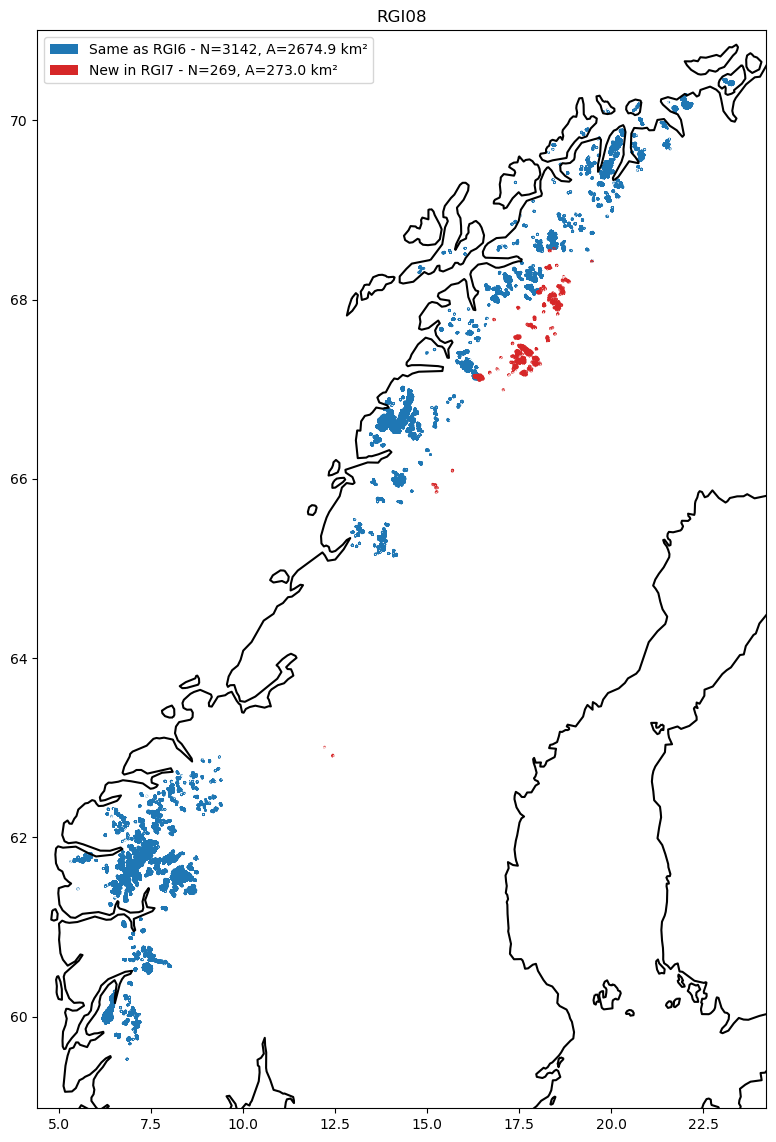

In [20]:
plot_map(rgi7, reg, loc='upper left', linewidth=2, is_rgi6=True)

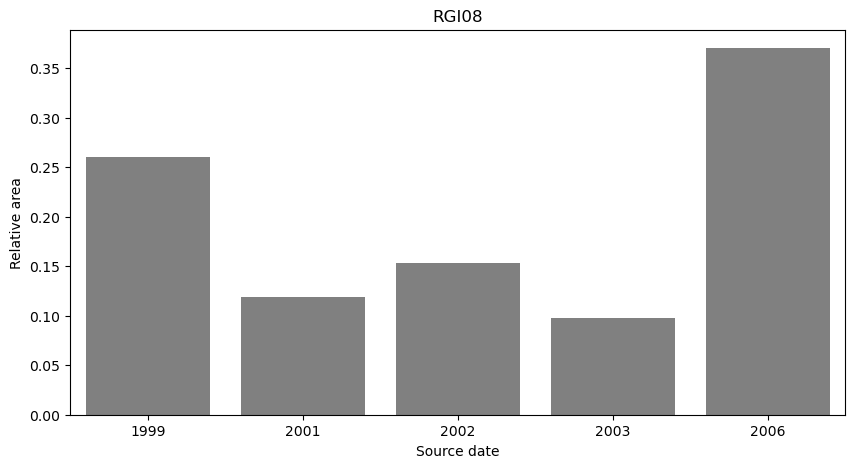

In [21]:
plot_date_hist(rgi7, reg)

### Text for github

In [22]:
fgh = sdf.T
fgh

subm_id,611,812
N,3142,269
A,2674.9,273.0
analysts,"Andreassen, Winsvold","Brown, Frank, Hansson"
submitters,Winsvold,Frank
release_date,2012,2023
geog_area,Norway,Sweden
src_date_mode,2006,2002
src_date_min,1999,1999
src_date_max,2006,2002


In [23]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 611                  | 812                   |
|:--------------|:---------------------|:----------------------|
| N             | 3142                 | 269                   |
| A             | 2674.9               | 273.0                 |
| analysts      | Andreassen, Winsvold | Brown, Frank, Hansson |
| submitters    | Winsvold             | Frank                 |
| release_date  | 2012                 | 2023                  |
| geog_area     | Norway               | Sweden                |
| src_date_mode | 2006                 | 2002                  |
| src_date_min  | 1999                 | 1999                  |
| src_date_max  | 2006                 | 2002                  |


## Write out and tar 

In [24]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI08/
RGI08/RGI08.shx
RGI08/RGI08.prj
RGI08/RGI08.cpg
RGI08/RGI08.dbf
RGI08/RGI08.shp
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI08.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI08'], returncode=0)


## Consistency check with RGI6 

In [28]:
# load reference data
from utils import open_zip_shapefile
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [29]:
len(rgi7), len(rgi6)

(3411, 3417)

In [30]:
# Select only the relevant parts for the rest of the tests:
# rp = rgi7.representative_point()
# rp = rp.to_frame('geometry')
# rp['orig_index'] = rgi7.index
# difference = gpd.overlay(rp, hull, how='difference')
# rgi7 = rgi7.loc[difference['orig_index']].copy()

# rp = rgi6.representative_point()
# rp = rp.to_frame('geometry')
# rp['orig_index'] = rgi6.index
# difference = gpd.overlay(rp, hull, how='difference')
# rgi6 = rgi6.loc[difference['orig_index']].copy()

Test the areas:

In [31]:
rgi6['area'] = rgi6.to_crs({'proj':'cea'}).area 
rgi7['area'] = rgi7.to_crs({'proj':'cea'}).area 

In [32]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['Area'].sum())
print('Area RGI6 computed by us (km2)', rgi6['area'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['area'].sum() - rgi7['area'].sum()) * 1e-6)

Area RGI7a (km2) 2947.889517361984
Area RGI6 (km2) 2949.103
Area RGI6 computed by us (km2) 2949.088114785122
diff areas RGI6 - RGI7 computed by us (km2) 1.1985974231376648
